<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/WDSS_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data processing

In [68]:
# Load .txt file data and create DataFrame

with open("Train_text.txt") as f:
    train_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Train_labels.txt") as f:
    train_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
with open("Test_text.txt") as f:
    test_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Test_labels.txt") as f:
    test_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
text_df = pd.concat([train_text, test_text]).reset_index()
labels_df = pd.concat([train_lab, test_lab]).reset_index()
sentiment_df = pd.concat([text_df, labels_df], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_df.head(10)

In [73]:
# Clean data

labels = list(sentiment_df["Sentiment"])

stopword = nltk.corpus.stopwords.words('english')
stopword = [re.sub("[^a-z]", "", word) for word in stopword] # Filter punctuation

tweets_clean = []
for i in range(len(sentiment_df)):
    tweet_raw = sentiment_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

In [78]:
# Class Summary

print("Number of tweets is: {}.".format(len(tweets_clean)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==2),100*sum(np.array(labels)==2)/len(labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==1),100*sum(np.array(labels)==1)/len(labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==0),100*sum(np.array(labels)==0)/len(labels)))

Number of tweets is: 57899.
Number of positive tweets is: 20224 (or 34.9%).
Number of neutral tweets is: 26610 (or 46.0%).
Number of negative tweets is: 11065 (or 19.1%).


In [79]:
# Shuffle the data.

tweets_clean, labels = zip(*random.sample(list(zip(tweets_clean,labels)), len(tweets_clean)))
tweets_clean = list(tweets_clean)
labels = list(labels)

# Train-test split.

trainsize = int(len(tweets_clean)*0.8)

train_tweets, train_labels = tweets_clean[:trainsize], labels[:trainsize]
test_tweets, test_labels = tweets_clean[trainsize:], labels[trainsize:]

In [80]:
# Check distribution of training classes

print("TRAINING SET")
print("Number of tweets is: {}.".format(len(train_labels)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==0),100*sum(np.array(train_labels)==0)/len(train_labels)))

TRAINING SET
Number of tweets is: 46319.
Number of positive tweets is: 16162 (or 34.9%).
Number of neutral tweets is: 21328 (or 46.0%).
Number of negative tweets is: 8829 (or 19.1%).


In [83]:
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size)
tokenizer.fit_on_texts(train_tweets)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

# Pad sequences to standardise input sequence length.

train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

## Model Training

In [86]:
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

In [89]:
# Compile model.
embedding_dim = 32

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_1.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_1.summary()

# Train model.
history_1 = model_1.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=10,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          640000    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 640,099
Trainable params: 640,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1448/1448 - 6s - loss: 0.9724 - accuracy: 0.5312 - val_loss: 0.8893 - val_accuracy: 0.5801 - 6s/epoch - 4ms/step
Epoch 2/10
1448/1448 - 5s - loss: 0.8235 - accuracy: 0.6193 - val_loss: 0.8206 - val_accuracy: 0.6218 - 5s/epoch - 4ms/ste

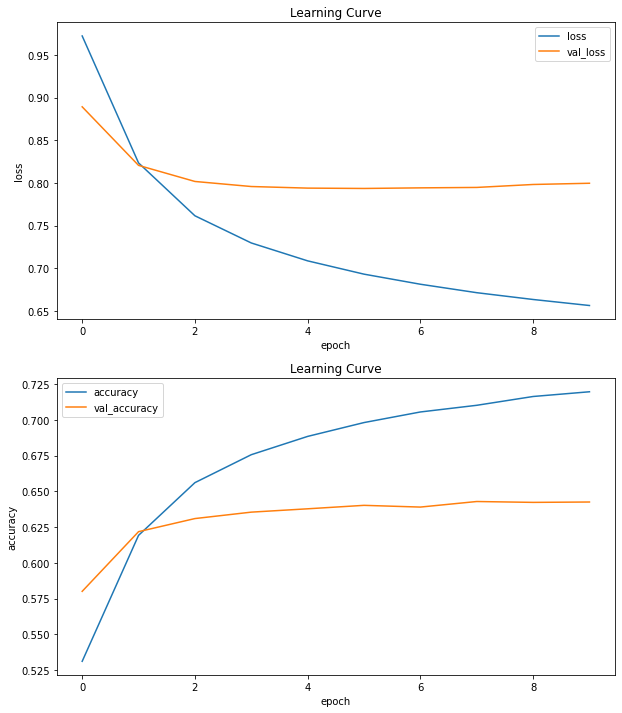

In [90]:
# Plot learning curve.
learning_curve(history_1)

In [124]:
x = tf.keras.layers.Embedding(vocab_size, embedding_dim) ( train_padded )
x.shape

TensorShape([46319, 20, 32])

In [127]:
y = tf.keras.layers.Conv1D(filters=16, kernel_size=3, input_shape=(20,32)) (x)
y.shape

TensorShape([46319, 18, 16])

In [136]:
z = tf.keras.layers.GlobalAveragePooling1D() (y)
z.shape

TensorShape([46319, 16])

In [130]:
a = tf.keras.layers.Flatten() (z)
a.shape

TensorShape([46319, 144])

In [133]:
b = tf.keras.layers.Dense(3, activation="softmax", input_shape=(None, 144)) (a)
b.shape

TensorShape([46319, 3])

In [142]:
# Compile model.
embedding_dim = 32

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_2.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_2.summary()

# Train model.
history_2 = model_2.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=10,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, None, 32)          640000    
                                                                 
 conv1d_31 (Conv1D)          (None, None, 8)           776       
                                                                 
 global_average_pooling1d_6   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 3)                 27        
                                                                 
Total params: 640,803
Trainable params: 640,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1448/1448 - 9s - loss: 0.9438 - accuracy: 0.5460 - val_loss: 0.8639 - val_accuracy: 0.5858 - 9s/epoch 

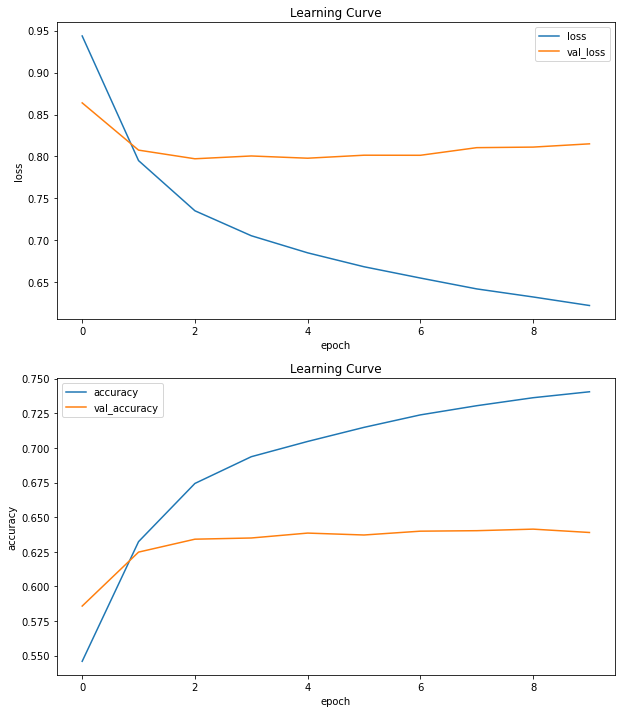

In [143]:
# Plot learning curve.
learning_curve(history_2)

In [149]:
# Compile model.
embedding_dim = 32

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation="relu"),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_3.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_3.summary()

# Train model.
history_3 = model_3.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=20,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 32)          640000    
                                                                 
 conv1d_37 (Conv1D)          (None, None, 8)           776       
                                                                 
 average_pooling1d_2 (Averag  (None, None, 8)          0         
 ePooling1D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, None, 8)           0         
                                                                 
 conv1d_38 (Conv1D)          (None, None, 16)          400       
                                                                 
 global_average_pooling1d_10  (None, 16)               0         
  (GlobalAveragePooling1D)                           

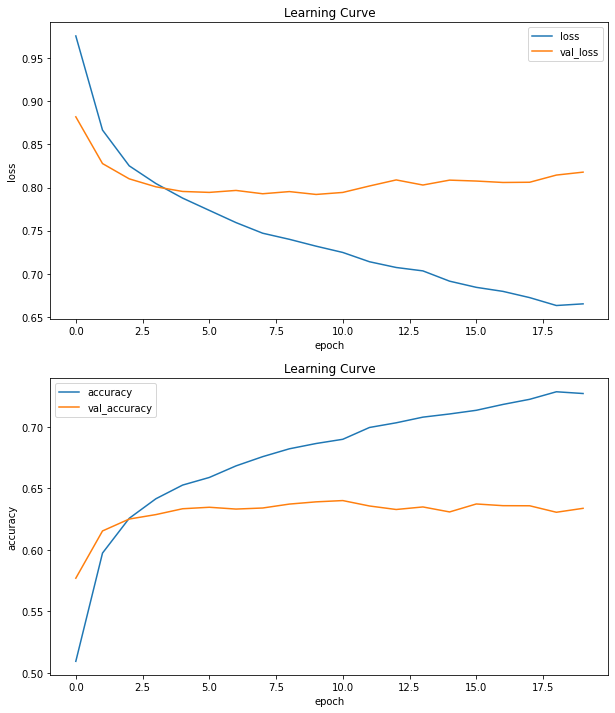

In [150]:
# Plot learning curve.
learning_curve(history_3)

In [161]:
# Compile model.
embedding_dim = 16

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_4.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_4.summary()

# Train model.
history_4 = model_4.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=20,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, None, 16)          320000    
                                                                 
 conv1d_46 (Conv1D)          (None, None, 64)          3136      
                                                                 
 global_average_pooling1d_18  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 8)                 520       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                     

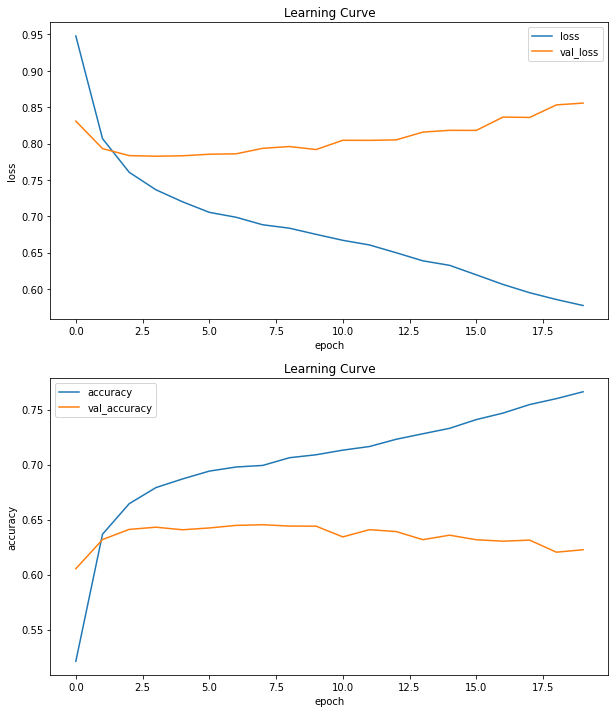

In [164]:
# Plot learning curve.
learning_curve(history_4)

In [168]:
# Compile model.
embedding_dim = 16

model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(units=2, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_5.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_5.summary()

# Train model.
history_5 = model_5.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=10,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 16)          320000    
                                                                 
 dropout_15 (Dropout)        (None, None, 16)          0         
                                                                 
 lstm_2 (LSTM)               (None, 2)                 152       
                                                                 
 dropout_16 (Dropout)        (None, 2)                 0         
                                                                 
 dense_45 (Dense)            (None, 3)                 9         
                                                                 
Total params: 320,161
Trainable params: 320,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1448/1448 - 28s - loss: 1.0150 - acc

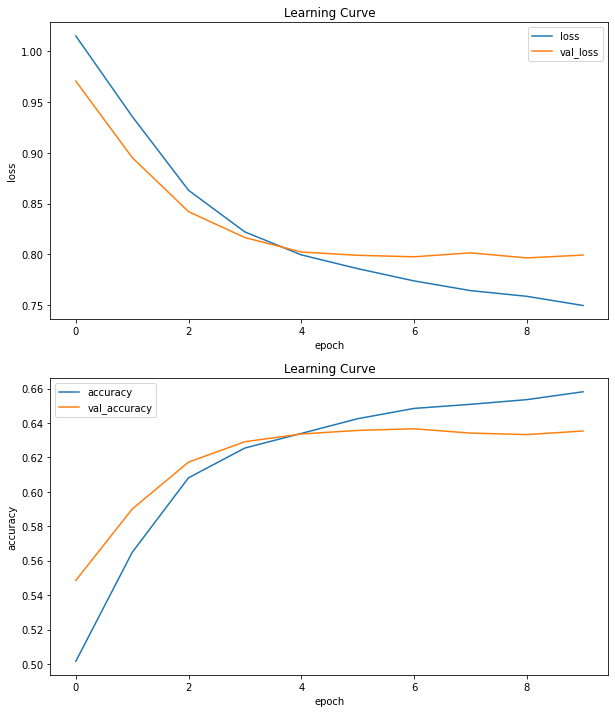

In [169]:
# Plot learning curve.
learning_curve(history_5)

In [ ]:
# Compile model.
embedding_dim = 16
lstm_units = 4

model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_6.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_6.summary()

# Train model.
history_6 = model_6.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=10,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          320000    
                                                                 
 lstm (LSTM)                 (None, 4)                 336       
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                                                                 
Total params: 320,351
Trainable params: 320,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1448/1448 - 30s - loss: 0.9777 - accuracy: 0.5071 - val_loss: 0.8784 - val_accuracy: 0.5803 - 30s/epoch - 21ms/step
Epoch 2/10
1448/1448 - 27s - loss: 0.8383 - accuracy: 0.6104 - val_loss: 0.7975 - val_accuracy: 0.6370 - 27s/epoch - 18ms/step
Epoch 3/10
1448/1448 - 27s - loss: 0.7716 - accuracy: 0.65

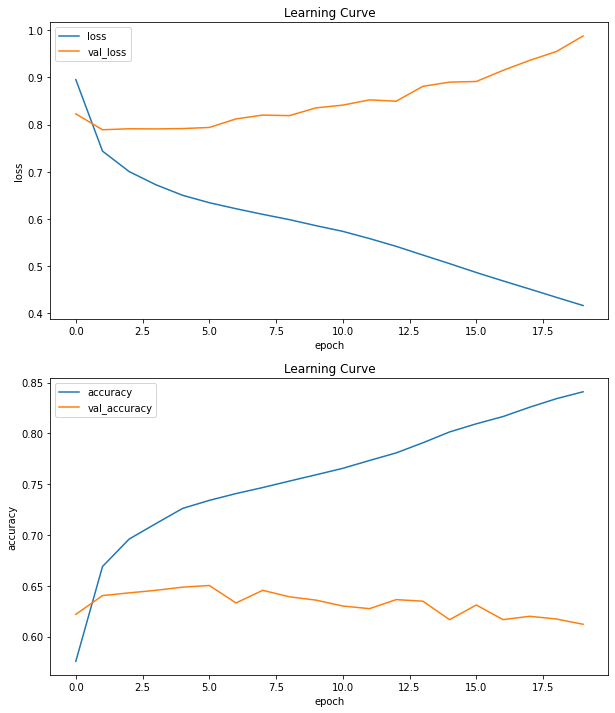

In [153]:
# Plot learning curve.
learning_curve(history_6)